# Model Training - MobileNetV3 (transfer + data augmentation)

### 0. Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.applications import MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input
from keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.metrics import Precision, Recall
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

### 1. Paths

In [2]:
# DATASET_BASE_TRAIN_PATH = "/Users/adamdabkowski/DataspellProjects/Praca_dyplomowa/data/train_resized"
# DATASET_BASE_TRAIN_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/train_resized"
# DATASET_BASE_TRAIN_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/train_merged"
DATASET_BASE_TRAIN_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/train_merged_cleaned"

# DATASET_BASE_TRAIN_PATH = "../new_data"

# DATASET_BASE_TEST_PATH = "/Users/adamdabkowski/DataspellProjects/Praca_dyplomowa/data/test_resized"
DATASET_BASE_TEST_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/test_resized"

### 2. Data preprocessing

In [3]:
batch_size  = 32
img_size = 224

train_validation_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_validation_data_generator.flow_from_directory(
    DATASET_BASE_TRAIN_PATH,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training',
    shuffle=True,
)

validation_generator = train_validation_data_generator.flow_from_directory(
    DATASET_BASE_TRAIN_PATH,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=True,
)

Found 23689 images belonging to 7 classes.
Found 5919 images belonging to 7 classes.


### 5. Model creating

In [4]:
CATEGORIES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [5]:
checkpoint = ModelCheckpoint(
    filepath="./model_mobilenet_v3_transfer_data_augmentation.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=0.00001,
)

callbacks_list = [early_stopping, checkpoint, reduce_learning_rate]

In [6]:
model = Sequential()

base_model = MobileNetV3Large(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
model.add(base_model)

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [7]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Precision(class_id=0, name='precision_angry'),
        Precision(class_id=1, name='precision_disgust'),
        Precision(class_id=2, name='precision_fear'),
        Precision(class_id=3, name='precision_happy'),
        Precision(class_id=4, name='precision_neutral'),
        Precision(class_id=5, name='precision_sad'),
        Precision(class_id=6, name='precision_surprise'),
        Recall(name='recall'),
        Recall(class_id=0, name='recall_angry'),
        Recall(class_id=1, name='recall_disgust'),
        Recall(class_id=2, name='recall_fear'),
        Recall(class_id=3, name='recall_happy'),
        Recall(class_id=4, name='recall_neutral'),
        Recall(class_id=5, name='recall_sad'),
        Recall(class_id=6, name='recall_surprise'),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               492032    
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 3,491,975
Trainable params: 3,467,575
Non-trainable params: 24,400
_________________________________________________________________


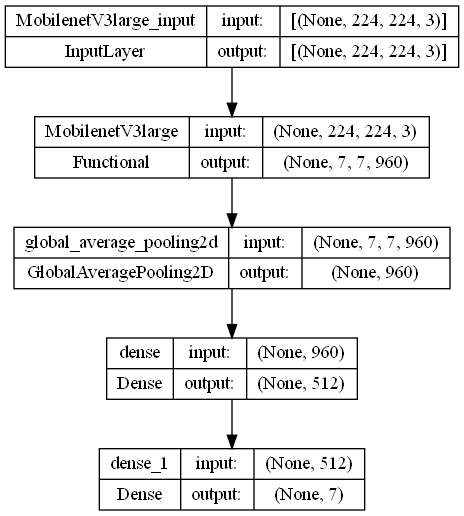

In [8]:
plot_model(model, to_file='model_mobilenet_v3_transfer_data_augmentation.png', show_shapes=True, show_layer_names=True)

### 6. Model training

In [9]:
epochs = 50

In [10]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//validation_generator.batch_size,
    callbacks=callbacks_list,
)

Epoch 1/50
740/740 [==============================] - ETA: 0s - loss: 1.3225 - accuracy: 0.4969 - precision: 0.7084 - precision_angry: 0.6147 - precision_disgust: 0.3889 - precision_fear: 0.4771 - precision_happy: 0.8108 - precision_neutral: 0.5889 - precision_sad: 0.4903 - precision_surprise: 0.6965 - recall: 0.2808 - recall_angry: 0.1245 - recall_disgust: 0.0277 - recall_fear: 0.0309 - recall_happy: 0.6355 - recall_neutral: 0.2063 - recall_sad: 0.0906 - recall_surprise: 0.4483
Epoch 1: val_loss improved from inf to 15.20419, saving model to .\model_mobilenet_v3_transfer_data_augmentation.h5
740/740 [==============================] - 1160s 2s/step - loss: 1.3225 - accuracy: 0.4969 - precision: 0.7084 - precision_angry: 0.6147 - precision_disgust: 0.3889 - precision_fear: 0.4771 - precision_happy: 0.8108 - precision_neutral: 0.5889 - precision_sad: 0.4903 - precision_surprise: 0.6965 - recall: 0.2808 - recall_angry: 0.1245 - recall_disgust: 0.0277 - recall_fear: 0.0309 - recall_happy: 

### 7. Evaluation - Test set

In [3]:
from keras.models import load_model

model = load_model("model_mobilenet_v3_transfer_data_augmentation.h5")

In [4]:
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    DATASET_BASE_TEST_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7178 images belonging to 7 classes.


In [5]:
model.evaluate(test_generator)

225/225 [==============================] - 83s 356ms/step - loss: 1.0729 - accuracy: 0.6918 - precision: 0.7235 - precision_angry: 0.6059 - precision_disgust: 0.7639 - precision_fear: 0.6409 - precision_happy: 0.9073 - precision_neutral: 0.6319 - precision_sad: 0.6207 - precision_surprise: 0.8230 - recall: 0.6658 - recall_angry: 0.6211 - recall_disgust: 0.4955 - recall_fear: 0.4131 - recall_happy: 0.8777 - recall_neutral: 0.6821 - recall_sad: 0.5156 - recall_surprise: 0.8002


[1.0728745460510254,
 0.6918361783027649,
 0.7235427498817444,
 0.6059063076972961,
 0.7638888955116272,
 0.6409090757369995,
 0.9073426723480225,
 0.6318557262420654,
 0.6206563711166382,
 0.823019802570343,
 0.6657843589782715,
 0.6210855841636658,
 0.4954954981803894,
 0.4130859375,
 0.8776775598526001,
 0.6820762157440186,
 0.5156375169754028,
 0.800240695476532]